In [2]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import graspologic as gl
from celegans_connectome_analysis.get_nx import get_adult_c_elegans_nx,get_fxnl_nx

In [3]:
G_fx = get_fxnl_nx()
G_stx = get_adult_c_elegans_nx()

/home/gwyneth-local/celegans_connectome_analysis/celegans_connectome_analysis/get_nx.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["neuron type"] = df["neuron type"].fillna(method='ffill')


In [4]:
# goal: make a di_graph that contants functional and structural information
fx_nodes = set(G_fx.nodes())
stx_nodes = set(G_stx.nodes())

print(stx_nodes - fx_nodes)
print(fx_nodes - stx_nodes)

{'ALNL', 'AIAR', 'BWM-VR01', 'SIAVL', 'AVM', 'SIADR', 'SDQL', 'ALML', 'PVNR', 'BWM-VR08', 'PLNL', 'DVC', 'RMHR', 'GLRDL', 'BWM-VL08', 'BWM-DR07', 'BWM-DL07', 'CEPshDR', 'BWM-DR02', 'BWM-VL05', 'BWM-VR05', 'BWM-DL01', 'BWM-DL03', 'AIAL', 'AVFR', 'BWM-DL02', 'BWM-VL04', 'PVQL', 'PVPR', 'BWM-DL05', 'PVR', 'BWM-DR06', 'PVPL', 'CEPshVR', 'CANL', 'CANR', 'ALNR', 'RIFL', 'BWM-VL01', 'SIADL', 'BWM-VR04', 'BWM-DR08', 'HSNL', 'CEPshVL', 'RIPR', 'HSNR', 'SIBDL', 'IL1L', 'DVA', 'SIAVR', 'BWM-DL06', 'SIBDR', 'BWM-VL02', 'SIBVL', 'BWM-DL08', 'ADFR', 'BDUR', 'RMHL', 'GLRVL', 'SDQR', 'PVQR', 'BWM-VR03', 'PVT', 'BWM-VL06', 'BDUL', 'GLRDR', 'GLRR', 'GLRVR', 'BWM-VR07', 'PVCR', 'PVNL', 'BWM-VR06', 'BWM-DL04', 'BWM-DR05', 'BWM-VR02', 'BWM-DR03', 'CEPshDL', 'BWM-DR01', 'IL2VR', 'PVCL', 'PLNR', 'ALMR', 'GLRL', 'BWM-VL07', 'BWM-DR04', 'BWM-VL03'}
{'VB1', 'DD1', 'M2L', 'SABVL', 'I2R', 'AS1', 'SABVR', 'I1L', 'I3', 'IL2V4', 'I4', 'I1R', 'NSML', 'MCL', 'VA1', 'MCR', 'M1', 'I2L', 'DA1', 'SABD', 'AVG', 'MI', 'M2R'

In [21]:
def combined_graph(stx, fx):
    G = nx.DiGraph()
    transfer_info(G, fx, 'fx_weight')
    transfer_info(G, stx, 'stx_weight')
    return G

def transfer_info(G: nx.DiGraph, source: nx.DiGraph, weight_label: str):
    for node in source.nodes():
        if node not in G.nodes():
            G.add_node(node)
        
        G.nodes[node]['neuron type'] = source.nodes[node]['neuron type']
        # add out edge information
        for target, infos in source[node].items():
            if not G.has_edge(node, target):
                G.add_edge(node, target)
            renamed_infos = {weight_label: infos['weight']}
            G[node][target].update(renamed_infos)

In [22]:
G = combined_graph(G_stx, G_fx)
print(G)

DiGraph with 254 nodes and 5108 edges


In [7]:
# mini tests

# test 1: check if all fx nodes are in G
def check_fx(G: nx.DiGraph, fx_nodes: set):
    for node in fx_nodes:
        assert node in G.nodes(), f"Node {node} not in G"

# test 2: check if all stx nodes are in G
def check_stx(G: nx.DiGraph, stx_nodes: set):
    for node in stx_nodes:
        assert node in G.nodes(), f"Node {node} not in G"

# test 3: check if all fx edges are in G and weights match
def check_fx_edges(G: nx.DiGraph, fx: nx.DiGraph):
    for node in fx.nodes():
        for target, infos in fx[node].items():
            assert G[node][target]['fx_weight'] == infos['weight'], f"Weight mismatch between G and fx"

# test 4: check if all stx edges are in G and weights match
def check_stx_edges(G: nx.DiGraph, stx: nx.DiGraph):
    for node in stx.nodes():
        for target, infos in stx[node].items():
            assert G[node][target]['stx_weight'] == infos['weight'], f"Weight mismatch between G and stx"

# test 5: check if all nodes have stx neuron type attribute
def check_neuron_type(G: nx.DiGraph, stx: nx.DiGraph):
    for node in stx.nodes():
        assert G.nodes[node]['neuron type'] == stx.nodes[node]['neuron type'], f"Neuron type mismatch between G and stx"

In [8]:
# run tests
check_fx(G, fx_nodes)
check_stx(G, stx_nodes)
check_fx_edges(G, G_fx)
check_stx_edges(G, G_stx)
check_neuron_type(G, G_stx)

In [9]:
# save graph
nx.write_gpickle(G, 'combined_graph.gpickle')

In [10]:
# load and test
G_loaded = nx.read_gpickle('data/combined_graph.gpickle')
check_fx(G_loaded, fx_nodes)
check_stx(G_loaded, stx_nodes)
check_fx_edges(G_loaded, G_fx)
check_stx_edges(G_loaded, G_stx)
check_neuron_type(G_loaded, G_stx)

In [11]:
muscle_nodes = [n for n in G_loaded.nodes if G_loaded.nodes[n]["neuron type"] == "Muscle"]

# Remove muscle nodes from G_loaded
G_loaded.remove_nodes_from(muscle_nodes)

In [12]:
category_order = {'Sens.': 0, 'Inter.': 1, 'Mot.': 2, 'Mod.': 3, 'Other': 4}

ordered_nodes = sorted(G_loaded.nodes(), key=lambda n: (category_order[G_loaded.nodes[n]["neuron type"]], -1 * (n in G_fx.nodes() and n in G_stx.nodes())))

stx_adj_matrix = nx.adjacency_matrix(G_loaded, nodelist=ordered_nodes, weight='stx_weight').todense()
fx_adj_matrix = nx.adjacency_matrix(G_loaded, nodelist=ordered_nodes, weight='fx_weight').todense()

neuron_types = [G_loaded.nodes[n]["neuron type"] for n in ordered_nodes]

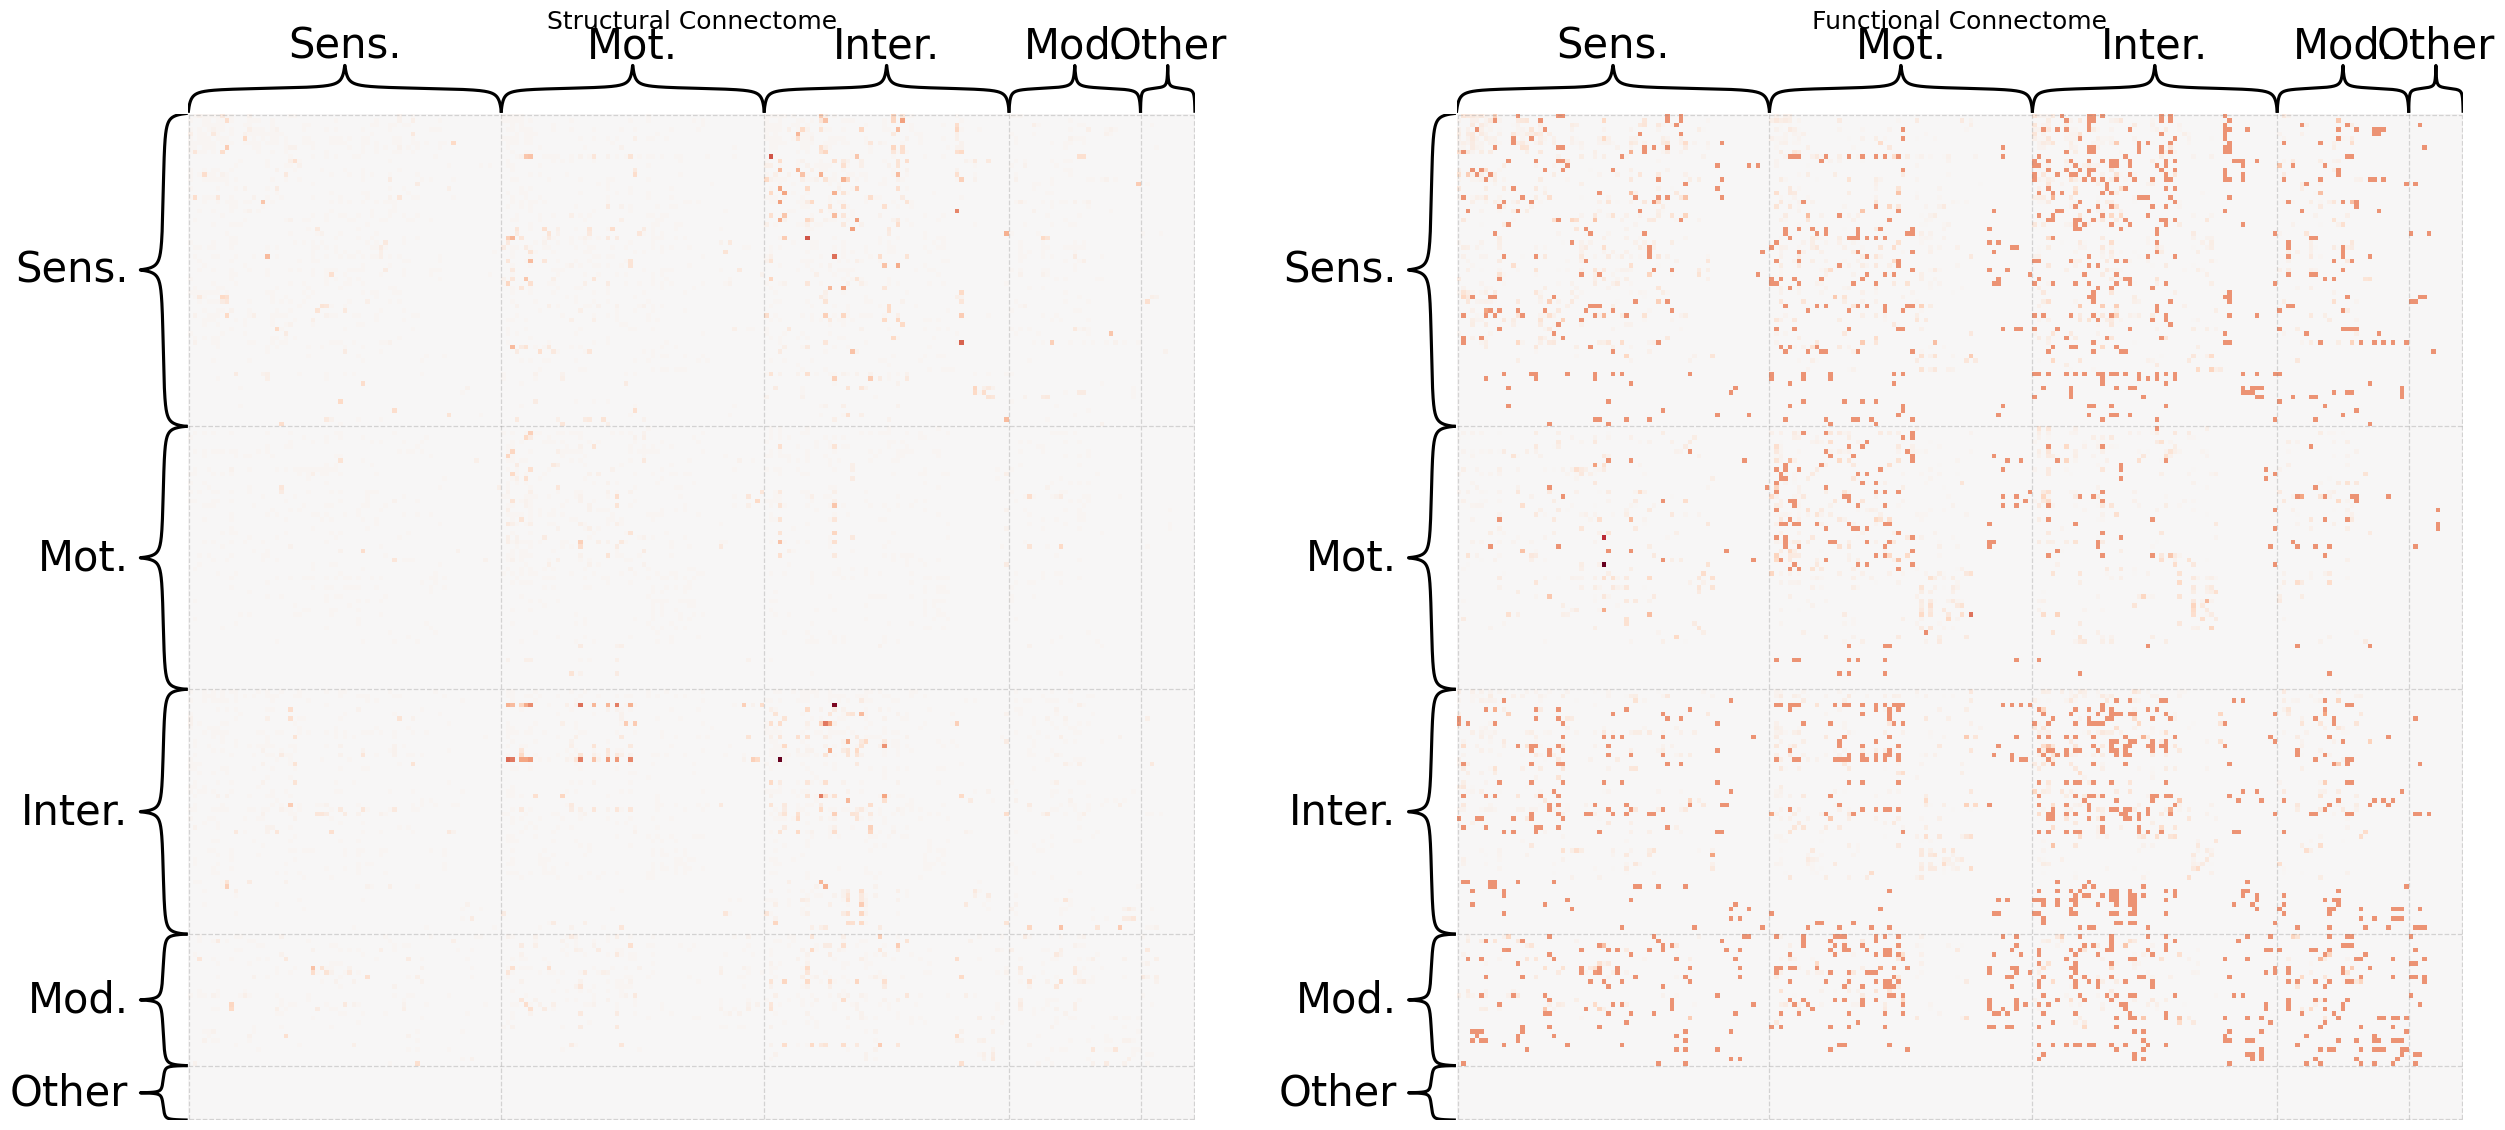

In [13]:
import numpy as np
stx_adj = np.asarray(stx_adj_matrix)
fx_adj = np.asarray(fx_adj_matrix)

title = "Side-by-side Connectomes for Structural and Functional Neuron Data"
fig, axes = plt.subplots(1, 2, figsize=(30, 14))

# Plot structural adjacency matrix
gl.plot.heatmap(stx_adj, inner_hier_labels=neuron_types, sort_nodes=False, title="Structural Connectome", ax=axes[0], cbar=False)

# Plot functional adjacency matrix
gl.plot.heatmap(fx_adj, inner_hier_labels=neuron_types, sort_nodes=False, title="Functional Connectome", ax=axes[1], cbar=False)
plt.show()


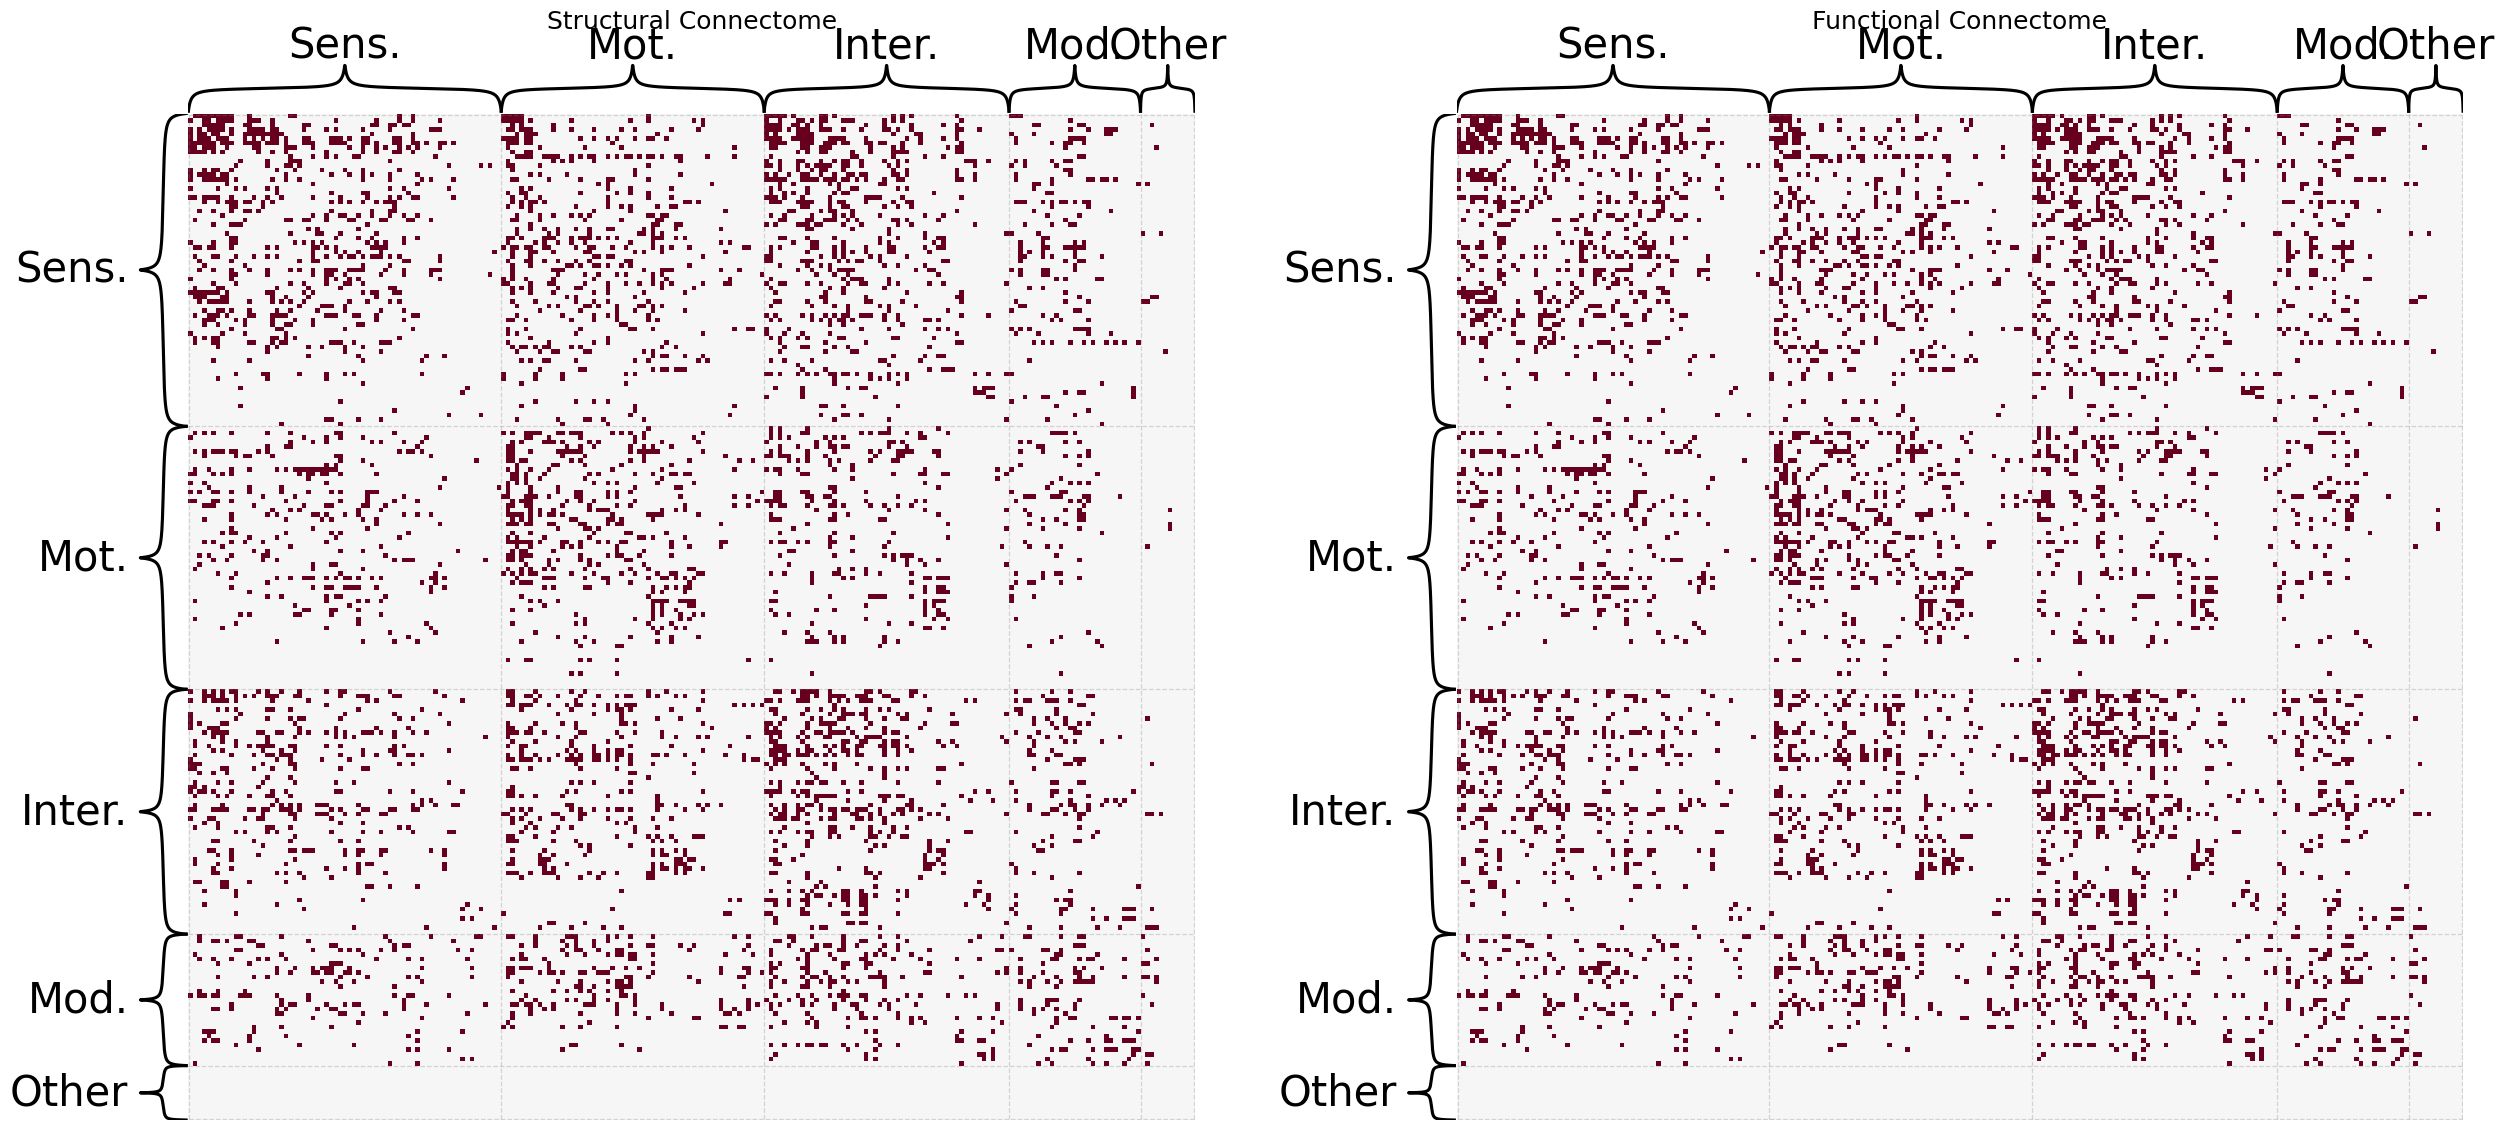

In [14]:
title = "Side-by-side Connectomes for Structural and Functional Neuron Data"
fig, axes = plt.subplots(1, 2, figsize=(30, 14))

# Plot structural adjacency matrix
gl.plot.heatmap(stx_adj>0, inner_hier_labels=neuron_types, sort_nodes=False, title="Structural Connectome", ax=axes[0], cbar=False)

# Plot functional adjacency matrix
gl.plot.heatmap(fx_adj>0, inner_hier_labels=neuron_types, sort_nodes=False, title="Functional Connectome", ax=axes[1], cbar=False)
plt.show()

In [16]:
binarized_stx_adj = stx_adj > 0
binarized_fx_adj = fx_adj > 0

# Calculate the Jaccard similarity between the two connectomes
jaccard_similarity = np.sum(np.logical_and(binarized_stx_adj, binarized_fx_adj)) / np.sum(np.logical_or(binarized_stx_adj, binarized_fx_adj))
print(f"Jaccard similarity: {jaccard_similarity}")

Jaccard similarity: 1.0


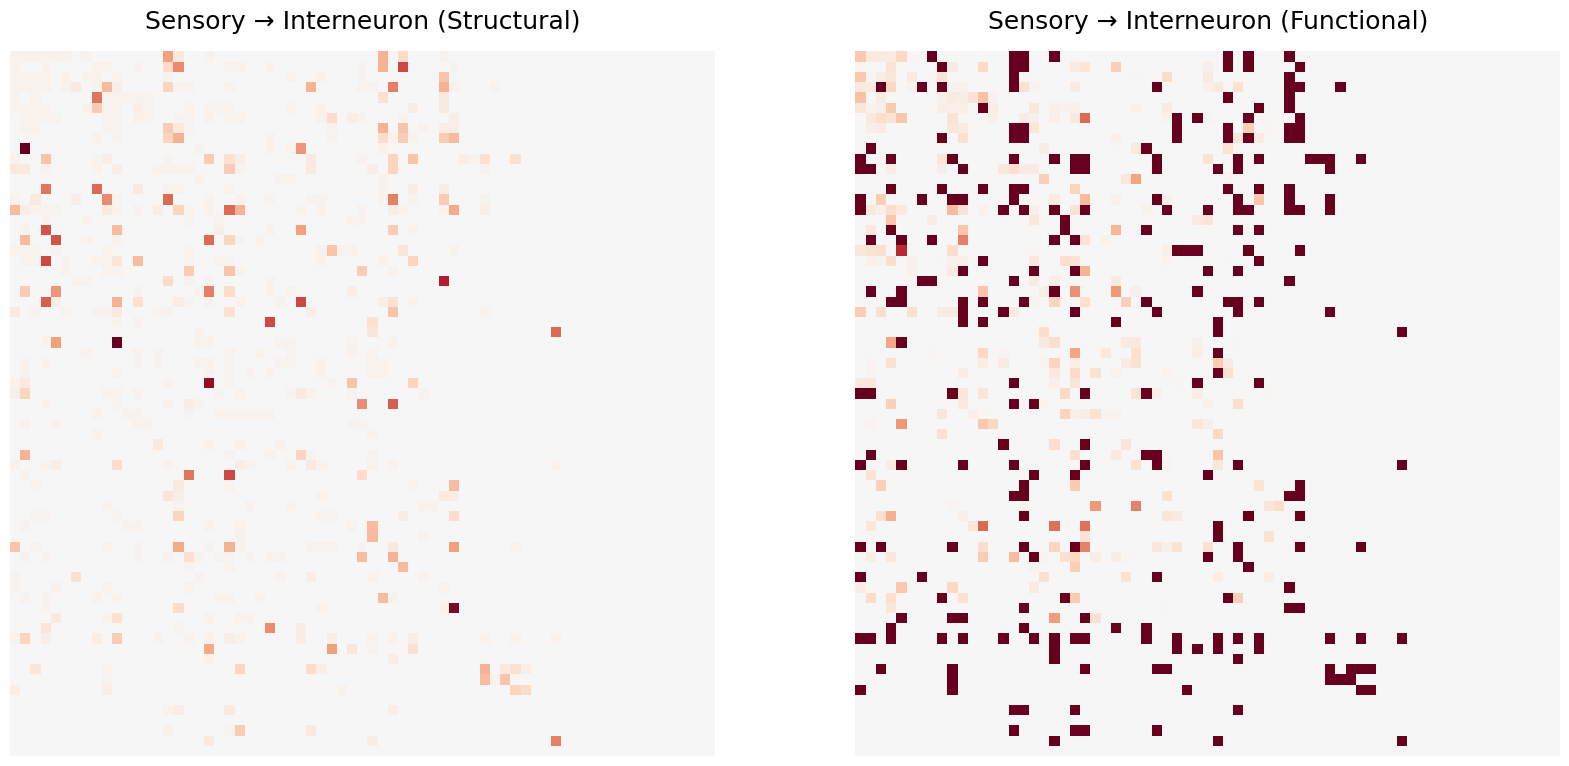

In [20]:
# zoom in on sensory to neuron connections
sensory_nodes = [n for n in G_loaded.nodes if G_loaded.nodes[n]["neuron type"] == "Sens."]
sensory_indices = [ordered_nodes.index(n) for n in sensory_nodes]
interneuron_nodes = [n for n in G_loaded.nodes if G_loaded.nodes[n]["neuron type"] == "Inter."]
interneuron_indices = [ordered_nodes.index(n) for n in interneuron_nodes]

sub_stx_adj = stx_adj[np.ix_(sensory_indices, interneuron_indices)]
sub_fx_adj = fx_adj[np.ix_(sensory_indices, interneuron_indices)]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
rows_stx, cols_stx = sub_stx_adj.shape
rows_fx, cols_fx = sub_fx_adj.shape

max_size = max(rows_stx, cols_stx)

padded_sub_stx_adj = np.zeros((max_size, max_size))
padded_sub_fx_adj = np.zeros((max_size, max_size))

padded_sub_stx_adj[:rows_stx, :cols_stx] = sub_stx_adj
padded_sub_fx_adj[:rows_fx, :cols_fx] = sub_fx_adj

gl.plot.heatmap(padded_sub_stx_adj, title="Sensory → Interneuron (Structural)", ax=axes[0], sort_nodes=False, cbar=False)
gl.plot.heatmap(padded_sub_fx_adj, title="Sensory → Interneuron (Functional)", ax=axes[1], sort_nodes=False, cbar=False)
plt.show()

## Analysis on Egg Laying Circuit

<img src="images/egg_laying_circuit.png" alt="Egg Laying Circuit Diagram" width="600"/>

In [28]:
# checking for all neurons existence in graph
egg_graph = nx.DiGraph()

# list of neurons given in diagram
egg_laying_neurons = ['BDU',
                      'HSN',
                      'VCn',
                      'RIF',
                      'AVF',
                      'AVG',
                      'PVN',
                      'AVJ',
                      'RIR',
                      'AVH',
                      'ADA',]

# name mapping
name_map = {'BDU':('BDUL', 'BDUR'),
            'HSN':('HSNL', 'HSNR'),
            'VCn':('VC1', 'VC2', 'VC3', 'VC4', 'VC5', 'VC6'),
            'RIF':('RIFL', 'RIFR'),
            'AVF':('AVFL', 'AVFR'),
            'AVG':('AVG',),
            'PVN':('PVNL', 'PVNR'),
            'AVJ':('AVJL', 'AVJR'),
            'RIR':('RIR',),
            'AVH':('AVHL', 'AVHR'),
            'ADA':('ADAL', 'ADAR'),}


print(G_loaded.nodes)
for _, names in name_map.items():
    for n in names:
        print(f"{n} in graph: {n in G_loaded.nodes}")

['ASEL', 'ADEL', 'ASER', 'ASGL', 'ASHL', 'AWAL', 'AWBL', 'AWBR', 'AWCL', 'AWCR', 'OLLL', 'AVDL', 'AVER', 'AVHL', 'AVJR', 'RIAL', 'RIBR', 'RICL', 'SABD', 'SIBVR', 'RMDDR', 'RMDVR', 'RMEL', 'SMDDL', 'VB1', 'ADER', 'AQR', 'FLPL', 'NSMR', 'ADAL', 'AINL', 'AVKL', 'M3L', 'ADFL', 'ADLL', 'ASHR', 'ASJR', 'AUAL', 'AUAR', 'AWAR', 'URXL', 'AIML', 'AIZL', 'AVDR', 'AVEL', 'I1R', 'RIGL', 'SAADR', 'SABVL', 'DB2', 'RMDDL', 'RMDVL', 'SMBDR', 'ASKL', 'BAGL', 'URAVL', 'ADAR', 'AIBL', 'AIBR', 'RIML', 'IL1DL', 'BAGR', 'FLPR', 'IL1DR', 'IL2DL', 'IL2DR', 'OLLR', 'OLQDL', 'OLQDR', 'OLQVR', 'URXR', 'URYDL', 'I3', 'RIAR', 'M3R', 'ALA', 'SAAVL', 'OLQVL', 'AVG', 'CEPDR', 'CEPVR', 'IL1VL', 'IL2V4', 'URBR', 'URYVL', 'URYVR', 'AINR', 'AVAR', 'AVBR', 'I2L', 'I6', 'RIPL', 'SAAVR', 'MCL', 'RMEV', 'SMBVR', 'VB2', 'I4', 'ASGR', 'ASIL', 'NSML', 'I2R', 'RIVL', 'M1', 'M2L', 'MI', 'RIBL', 'AIMR', 'AVBL', 'RIS', 'RMFR', 'ASIR', 'AVJL', 'AVKR', 'RIVR', 'RID', 'RMDR', 'IL2R', 'M2R', 'M5', 'IL1VR', 'RMER', 'IL2L', 'AIZR', 'RIFR'